<a href="https://colab.research.google.com/github/Ademola-Olorunnisola/Ademola-Olorunnisola.github.io/blob/main/Copy_of_Ademola_EKF_UKF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from scipy.integrate import odeint
import scipy.optimize

import sympy as sp

import pandas as pd

from scipy.integrate import odeint
import copy

In [ ]:

try:
    import casadi
except:
    !pip install casadi
    import casadi

try:
    import do_mpc
except:
    !pip install do_mpc
    import do_mpc

try:
    import pybounds
except:
    #!pip install pybounds
    !pip install git+https://github.com/vanbreugel-lab/pybounds
    import pybounds

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.1/164.1 kB 4.0 MB/s eta 0:00:00


/usr/local/lib/python3.12/dist-packages/do_mpc/sysid/__init__.py:15: UserWarning: The ONNX feature is not available. Please install the full version of do-mpc to access this feature.
  warnings.warn('The ONNX feature is not available. Please install the full version of do-mpc to access this feature.')
/usr/local/lib/python3.12/dist-packages/do_mpc/opcua/__init__.py:14: UserWarning: The opcua feature is not available. Please install the full version of do-mpc to access this feature.
  warnings.warn('The opcua feature is not available. Please install the full version of do-mpc to access this feature.')


  Cloning https://github.com/vanbreugel-lab/pybounds to /tmp/pip-req-build-069obm55
  Running command git clone --filter=blob:none --quiet https://github.com/vanbreugel-lab/pybounds /tmp/pip-req-build-069obm55
  Resolved https://github.com/vanbreugel-lab/pybounds to commit 96f12039ac9e1e3ef4381cd09a026f6bbf70ad5c
  Preparing metadata (setup.py) ... done
  Created wheel for pybounds: filename=pybounds-0.0.13-py3-none-any.whl size=19546 sha256=50895e1e1ce18b0c44742233ceeccaf8eb043d38f744228024dfd3880c2bef0e
  Stored in directory: /tmp/pip-ephem-wheel-cache-c47mha4j/wheels/cb/f8/fb/ff1887f9a2f35c3edad7b1acb7da69437c1fd8d885a800578d
Successfully built pybounds


In [ ]:
import sys
import requests
import importlib

def import_local_or_github(package_name, function_name=None, directory=None, giturl=None):
    # Import functions directly from github
    # Important: note that we use raw.githubusercontent.com, not github.com

    try: # to find the file locally
        if directory is not None:
            if directory not in sys.path:
                sys.path.append(directory)

        package = importlib.import_module(package_name)
        if function_name is not None:
            function = getattr(package, function_name)
            return function
        else:
            return package

    except: # get the file from github
        if giturl is None:
            giturl = 'https://raw.githubusercontent.com/Ademola-Olorunnisola/Nonlinear_and_Data_Driven_Estimation/main/Utility/' + str(package_name) + '.py'

        r = requests.get(giturl)
        print('Fetching from: ')
        print(r)

        # Store the file to the colab working directory
        with open(package_name+'.py', 'w') as f:
            f.write(r.text)
        f.close()

        # import the function we want from that file
        package = importlib.import_module(package_name)
        if function_name is not None:
            function = getattr(package , function_name)
            return function
        else:
            return package

tb_simulations = import_local_or_github('tb_simulations', directory='../Utility')
plot_tme = import_local_or_github('plot_utility', 'plot_tme', directory='../Utility')
extended_kalman_filter = import_local_or_github('extended_kalman_filter', directory='../Utility')
unscented_kalman_filter = import_local_or_github('unscented_kalman_filter', directory='../Utility')

Fetching from: 
<Response [200]>
Fetching from: 
<Response [200]>
Fetching from: 
<Response [200]>
Fetching from: 
<Response [200]>


$$
\mathbf{\dot{x}} = \mathbf{f}(\mathbf{x},\mathbf{u}) = \mathbf{f_0}(\mathbf{x}) + \mathbf{f_1}(\mathbf{x})\bbox[lightgreen]{\alpha} + \mathbf{f_2}(\mathbf{x})\bbox[lightgreen]{\kappa}
$$

$$
\frac{d}{dt}
\begin{bmatrix}
\bbox[yellow]{S} \\[0.3em]
\bbox[yellow]{V} \\[0.3em]
\bbox[yellow]{I} \\[0.3em]
\bbox[yellow]{R} \\[0.3em]
\bbox[pink]{\beta} \\[0.3em]
\bbox[pink]{\sigma}
\end{bmatrix} =
\overset{f_0}{\begin{bmatrix}
\bbox[lightblue]{\Lambda} - \bbox[pink]{\beta}\bbox[yellow]{SI} - \bbox[lightblue]{\mu}\bbox[yellow]{S} \\[0.3em]
0 - \bbox[pink]{\sigma}\bbox[pink]{\beta}\bbox[yellow]{VI} - \bbox[lightblue]{\mu}\bbox[yellow]{V} \\[0.3em]
\bbox[pink]{\beta}\bbox[yellow]{SI} + \bbox[pink]{\sigma}\bbox[pink]{\beta}\bbox[yellow]{VI} - \bbox[lightblue]{\gamma}\bbox[yellow]{I} - \bbox[lightblue]{\mu}\bbox[yellow]{I} \\[0.3em]
\bbox[lightblue]{\gamma}\bbox[yellow]{I} - \bbox[lightblue]{\mu}\bbox[yellow]{R}\\[0.3em]
0\\[0.3em]
0
\end{bmatrix}} +
\overset{f_1}{\begin{bmatrix}
-\bbox[yellow]{S} \\[0.3em]
\bbox[yellow]{S} \\[0.3em]
0 \\[0.3em]
0\\[0.3em]
0\\[0.3em]
0
\end{bmatrix}} \bbox[lightgreen]{\alpha} +
\overset{f_2}{\begin{bmatrix}
\bbox[pink]{\beta}\bbox[yellow]{SI} \\[0.3em]
\bbox[pink]{\sigma}\bbox[pink]{\beta}\bbox[yellow]{VI} \\[0.3em]
-\bbox[pink]{\beta}\bbox[yellow]{SI} - \bbox[pink]{\sigma}\bbox[pink]{\beta}\bbox[yellow]{VI} \\[0.3em]
0\\[0.3em]
0\\[0.3em]
0
\end{bmatrix}} \bbox[lightgreen]{\kappa}
$$

# Dynamics and measurement functions

In [ ]:
# all three measurement functions can be accessed from the planar drone script:
h_a = tb_simulations.H('h_ivr').h
h_b = tb_simulations.H('h_all_svir').h


In [ ]:
f = tb_simulations.F().f
h = h_b # choose one of the measurement functions

In [ ]:
h(None, None, return_measurement_names=True)

['S_absolute', 'V_absolute', 'I_absolute', 'R_absolute']

In [ ]:
def u_func(x_vec, t):
    """Simple vaccination and social distancing controller"""
    I = x_vec[2]

    # Vaccination rate: increase when infections are high
    I_threshold = 0.005  # 0.5% of population
    if I > I_threshold:
        alpha = 0.01  # 1% vaccination rate when infections high
    else:
        alpha = 0.005  # 0.5% baseline vaccination

    # Social distancing: activate when infections high
    if I > I_threshold:
        kappa = 0.3  # 30% reduction in contacts
    else:
        kappa = 0.1  # 10% baseline

    return np.array([alpha, kappa])

In [ ]:
def f_ode(x_vec, t):
    """Wrapper for odeint"""
    u_vec = u_func(x_vec, t)
    return f(x_vec, u_vec)


In [ ]:
N = 223000000
x0 = np.array([
    52309000/N,      # S: 0.2345 (23.45%)
    158330000/N,     # V: 0.7100 (71.00%)
    361000/N,        # I: 0.0016 (0.16%)
    12000000/N,      # R: 0.0538 (5.38%)
    0.00003,         # beta: realistic TB transmission (slow)
    0.85             # sigma: 85% vaccine efficacy
])

# Run simulation

In [ ]:
t_sim = np.arange(0, 365, 1.0)
result = odeint(f_ode, x0, t_sim)


In [ ]:
x_sim = {
    'S': result[:, 0],
    'V': result[:, 1],
    'I': result[:, 2],
    'R': result[:, 3],
    'beta': result[:, 4],
    'sigma': result[:, 5]
}

In [ ]:
u_sim = {'alpha': [], 'kappa': []}
for i in range(len(t_sim)):
    u = u_func(result[i], t_sim[i])
    u_sim['alpha'].append(u[0])
    u_sim['kappa'].append(u[1])

In [ ]:
y_sim_absolute = {
    'S_absolute': x_sim['S'] * N,
    'V_absolute': x_sim['V'] * N,
    'I_absolute': x_sim['I'] * N,
    'R_absolute': x_sim['R'] * N
}

# Simulate noisy measurements

In [ ]:
measurement_noise_stds = {
    'S_absolute': 100000.0,   # ±100K
    'I_absolute': 10000.0,    # ±10K
    'V_absolute': 100000.0,   # ±100K
    'R_absolute': 5000.0     # ±50K
}

In [ ]:
# Add noise
np.random.seed(42)
y_noisy_absolute = {
    key: y_sim_absolute[key] + np.random.normal(0, measurement_noise_stds[key], len(t_sim))
    for key in y_sim_absolute.keys()
}

In [ ]:
y_noisy = {key: y_noisy_absolute[key] / N for key in y_noisy_absolute.keys()}

<Axes: xlabel='Time', ylabel='R_absolute'>

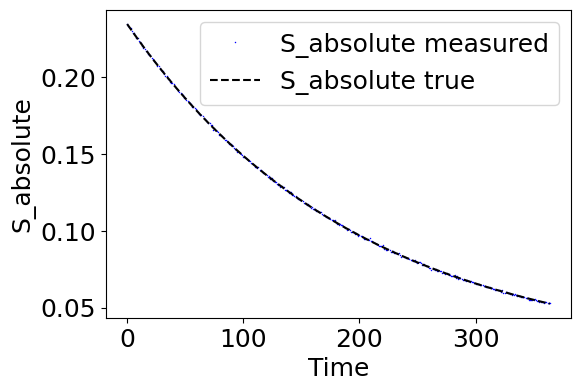

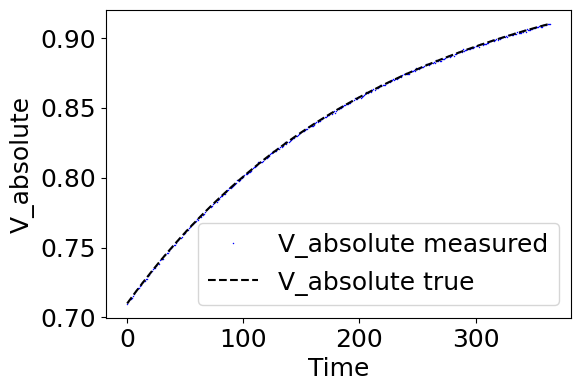

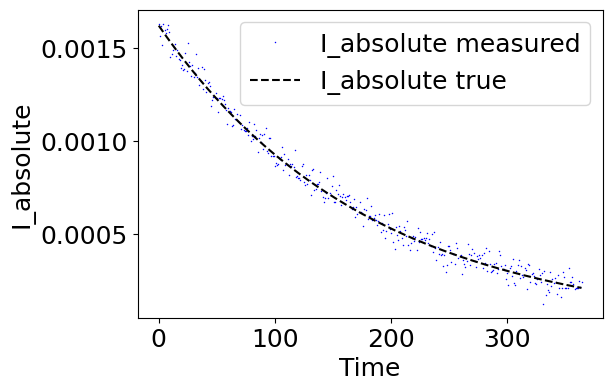

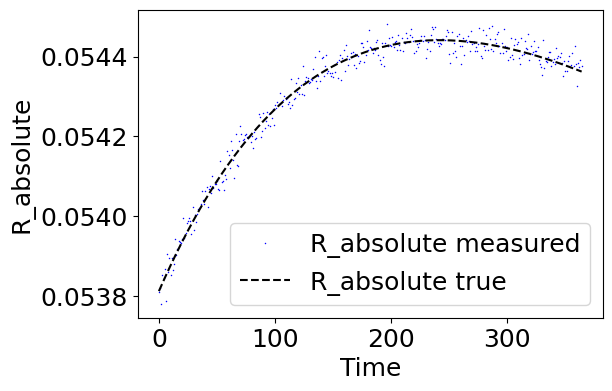

In [ ]:

plot_tme(t_sim, x_sim['S'], y_noisy['S_absolute'], label_var='S_absolute')
plot_tme(t_sim, x_sim['V'], y_noisy['V_absolute'], label_var='V_absolute')
plot_tme(t_sim, x_sim['I'], y_noisy['I_absolute'], label_var='I_absolute')
plot_tme(t_sim, x_sim['R'], y_noisy['R_absolute'], label_var='R_absolute')

### Save data as dataframes

In [ ]:
y_noisy_df = pd.DataFrame(y_noisy)
u_sim_df = pd.DataFrame(u_sim)

# Kalman filter parameters and initilization

In [ ]:
x0_ekf = np.array([x_sim['S'][0], x_sim['V'][0], x_sim['I'][0],
                   x_sim['R'][0], x_sim['beta'][0], x_sim['sigma'][0]])
u0 = np.array([u_sim['alpha'][0], u_sim['kappa'][0]])

In [ ]:
P0 = np.diag([0.01, 0.01, 0.001, 0.01, 0.00001, 0.01])
Q = np.diag([1e-6, 1e-6, 1e-7, 1e-6, 1e-10, 1e-10])
R_stds = np.array([100000/N, 100000/N, 10000/N, 50000/N])
R = np.diag(R_stds**2)

# Extended Kalman Filter

In [ ]:
EKF = extended_kalman_filter.EKF(
    f, h, x0_ekf, u0, P0, Q, R,
    dynamics_type='continuous',
    discretization_timestep=1.0,
    circular_measurements=(0, 0, 0, 0, 0, 0)
)

In [ ]:
EKF.estimate(y_noisy_df, u_sim_df)

In [ ]:
EKF.history.keys()

dict_keys(['X', 'U', 'Z', 'P', 'P_diags', 'R', 'Q', 'F', 'H', 'S', 'K', 'E', 'rho', 'Jk', 'inv_Jk'])

In [ ]:
# State estimate
x_est = pd.DataFrame(np.vstack(EKF.history['X']), columns=f(None,None,return_state_names=True))

In [ ]:
# Covariance diagonals
P_diags = np.vstack([np.diag(EKF.history['P'][i]) for i in range(len(EKF.history['P']))])
P_diags = pd.DataFrame(P_diags, columns=f(None,None,return_state_names=True))

## Plots

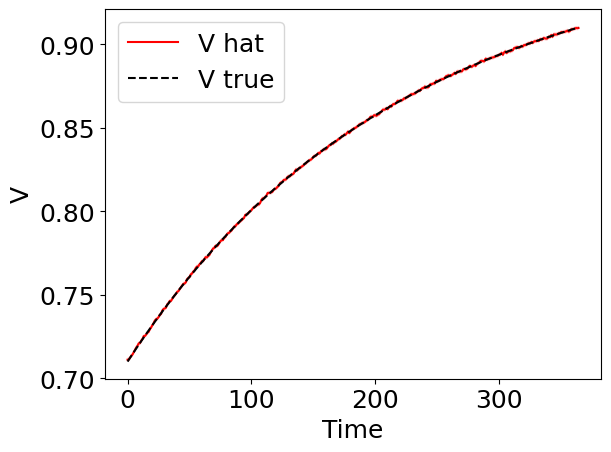

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)

state = 'V'

# Get the list of state names to find the correct index for 'V'
state_names = f(None, None, return_state_names=True)
v_index = state_names.index(state)

# Convert x_est and P_diags to numpy arrays and slice to get the 'V' column
x_est_v_col = np.array(x_est)[:, v_index]
P_diags_v_col = np.array(P_diags)[:, v_index]

# Use the extracted columns for plotting
plot_tme(t_sim, x_sim[state], None, x_est_v_col, label_var=state, ax=ax)

plus3sigma = x_est_v_col + 3*np.sqrt(P_diags_v_col)
minus3sigma = x_est_v_col - 3*np.sqrt(P_diags_v_col)

ax.fill_between(t_sim, plus3sigma, minus3sigma, facecolor='red', edgecolor='none', alpha=0.2)

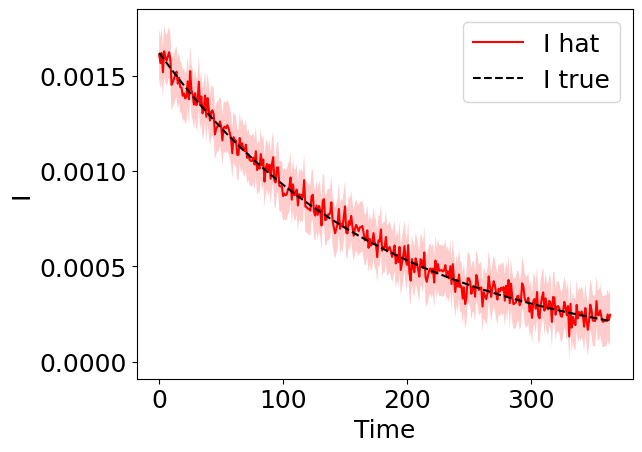

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)

state = 'I'

# Get the list of state names to find the correct index for 'I'
state_names = f(None, None, return_state_names=True)
I_index = state_names.index(state)

# Convert x_est and P_diags to numpy arrays and slice to get the 'I' column
x_est_i_col = np.array(x_est)[:, I_index]
P_diags_i_col = np.array(P_diags)[:, I_index]

# Use the extracted columns for plotting
plot_tme(t_sim, x_sim[state], None, x_est_i_col, label_var=state, ax=ax)

plus3sigma = x_est_i_col + 3*np.sqrt(P_diags_i_col)
minus3sigma = x_est_i_col - 3*np.sqrt(P_diags_i_col)

ax.fill_between(t_sim, plus3sigma, minus3sigma, facecolor='red', edgecolor='none', alpha=0.2)

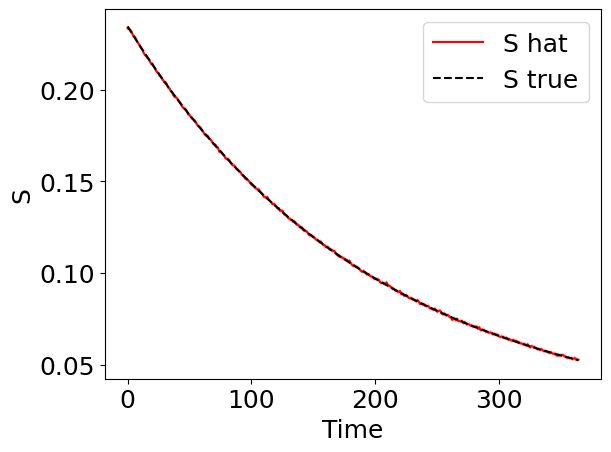

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)

state = 'S'

# Get the list of state names to find the correct index for 'S'
state_names = f(None, None, return_state_names=True)
s_index = state_names.index(state)

# Convert x_est and P_diags to numpy arrays and slice to get the 'S' column
x_est_s_col = np.array(x_est)[:, s_index]
P_diags_s_col = np.array(P_diags)[:, s_index]

# Use the extracted columns for plotting
plot_tme(t_sim, x_sim[state], None, x_est_s_col, label_var=state, ax=ax)

plus3sigma = x_est_s_col + 3*np.sqrt(P_diags_s_col)
minus3sigma = x_est_s_col - 3*np.sqrt(P_diags_s_col)

ax.fill_between(t_sim, plus3sigma, minus3sigma, facecolor='red', edgecolor='none', alpha=0.2)

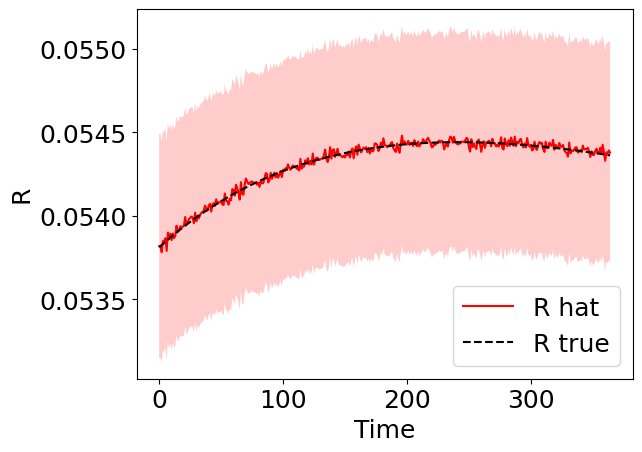

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)

state = 'R'

# Get the list of state names to find the correct index for 'R'
state_names = f(None, None, return_state_names=True)
R_index = state_names.index(state)

# Convert x_est and P_diags to numpy arrays and slice to get the 'R' column
x_est_r_col = np.array(x_est)[:, R_index]
P_diags_r_col = np.array(P_diags)[:, R_index]

# Use the extracted columns for plotting
plot_tme(t_sim, x_sim[state], None, x_est_r_col, label_var=state, ax=ax)

plus3sigma = x_est_r_col + 3*np.sqrt(P_diags_r_col)
minus3sigma = x_est_r_col - 3*np.sqrt(P_diags_r_col)

ax.fill_between(t_sim, plus3sigma, minus3sigma, facecolor='red', edgecolor='none', alpha=0.2)

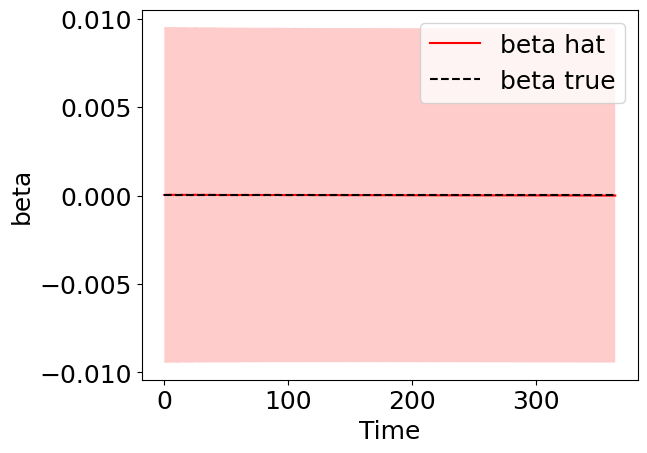

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)

state = 'beta'

# Get the list of state names to find the correct index for 'beta'
state_names = f(None, None, return_state_names=True)
beta_index = state_names.index(state)

# Convert x_est and P_diags to numpy arrays and slice to get the 'beta' column
x_est_beta_col = np.array(x_est)[:, beta_index]
P_diags_beta_col = np.array(P_diags)[:, beta_index]

# Use the extracted columns for plotting
plot_tme(t_sim, x_sim[state], None, x_est_beta_col, label_var=state, ax=ax)

plus3sigma = x_est_beta_col + 3*np.sqrt(P_diags_beta_col)
minus3sigma = x_est_beta_col - 3*np.sqrt(P_diags_beta_col)

ax.fill_between(t_sim, plus3sigma, minus3sigma, facecolor='red', edgecolor='none', alpha=0.2)

# Unscented Kalman Filter

In [ ]:
UKF = unscented_kalman_filter.UKF(f, h, x0, u0, P0, Q, R,
                                 dynamics_type='continuous', discretization_timestep=1.0,
                                 alpha=0.1)

In [ ]:
UKF.estimate(y_noisy_df, u_sim_df)

In [ ]:
UKF.history.keys()

dict_keys(['X', 'P', 'P_diags', 'sigma_points'])

In [ ]:
# State estimate
x_est = pd.DataFrame(np.vstack(UKF.history['X']), columns=f(None,None,return_state_names=True))

In [ ]:
# Covariance diagonals
P_diags = np.vstack([np.diag(UKF.history['P'][i]) for i in range(len(UKF.history['P']))])
P_diags = pd.DataFrame(P_diags, columns=f(None,None,return_state_names=True))

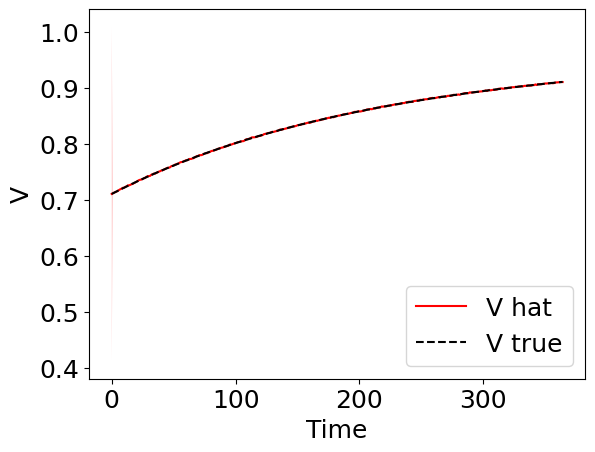

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)

state = 'V'

plot_tme(t_sim, x_sim[state], None, x_est[state], label_var=state, ax=ax)

plus3sigma = x_est[state] + 3*np.sqrt(P_diags[state])
minus3sigma = x_est[state] - 3*np.sqrt(P_diags[state])

ax.fill_between(t_sim, plus3sigma, minus3sigma, facecolor='red', edgecolor='none', alpha=0.2)